# US Recession prediction

This script contains the the development of a Keras Neural Nets-Classifier to predict recession probabilities in the US using Treasury term spreads.

The notebook is organized in the following way:
1) Data Sourcing from Fred
2) Data Manipulation
3) Model selection via grid search (evaluated on Time series Cross Validation)
4) Model evaluation on past recessions
5) Estimation on whole data set and prediction on current edge

# Import

In [9]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import Normalizer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from scikeras.wrappers import KerasClassifier
from keras import layers
import tensorflow as tf

In [10]:
features = ['T10Y3M', 'T10Y2Y']

### data import
In this section the data for which we will train the NN is sourced from FRED. Then, the data is transformed in order to fit the structure that will be used to train the ML-model.

In [11]:
# define start and end for which data is sourced
start = datetime(1980, 5, 1)
end = datetime(2022, 6, 20)

# append USREC to list of tickers that are sourced from FRED
source_data_list = features.copy()
source_data_list.append('USREC')
df = pdr.DataReader(source_data_list, 'fred', start, end)
df = df.ffill()

# handle NaNs and add Null (for plotting purpose in next fields)
df = df.dropna()
df['Null'] = 0

In [12]:
ratio = df['USREC'].value_counts()[0.0] / df['USREC'].value_counts()[1.0]
print('USREC binary has', str(round(ratio,1)), 'times more frequent realization 0 opposed to 1 -> Very inbalanced target')

USREC binary has 9.4 times more frequent realization 0 opposed to 1 -> Very inbalanced target


Problem that arises because of that: "In the case of class imbalances, ... , relatively robust procedures (evaluation metrics) used for unskewed data can break down miserably when the data is skewed."  Imbalanced Learning: Foundations, Algorithms, and Applications, 2013, p.187

For US, it was found that, during the model selection process (grid search) the imbalancedness of the target variable does not pose a huge problem. Even if the grid search is run for accuracy (which is a slightly more intuitive measure), the selected model does a good job. For Germany, this is different.

## transformation
In this section the target variable will be transformed. As we want to predict the indicator variable that captures the question: "How likely is a recession-start in the next 12 months starting from now?" it is needed to first obtain recession start dates and then to backfill the indicator for the 12 previous months.

In [13]:
df['start_recession'] = df['USREC'] - df['USREC'].shift(1)
df['start_recession'] = df['start_recession'].map(lambda x: np.nan if x != 1 else 1)

df['start_recession_next_12m'] = df['start_recession'].bfill(limit=252).fillna(0)

# for all dates from today to one year ago we do not know that a recession will not happen
datelist = pd.date_range(end = datetime.today().date(), periods = 360)
df.loc[df.index.isin(datelist), 'start_recession_next_12m'] = None

# Model selection
In this section, the model will be selected by a grid search algorithm. 

In [14]:
# drop redundant features
df = df.drop(['start_recession', 'Null', 'USREC'], axis=1)
df_total = df.copy()  # keep current edge for out-of-sample prediction
df = df.dropna()  # drops current edge, thus leaving only historic, labeled data
df.columns

# split df into X and y
X = df[features]
y = df['start_recession_next_12m']

## architecture
Define the NN's base architecture. Certain hyperparameters are kept flexible in order to perform the grid search.

In [15]:
def get_model(hidden_layer_dim, number_hidden_layers, dropout_rate, meta):
    # note that meta is a special argument that will be
    # handed a dict containing input metadata
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_features_in_, input_shape=X_shape_[1:], activation=keras.layers.Activation("relu")))
    for i in (0, number_hidden_layers):
        model.add(layers.Dropout(dropout_rate))
        model.add(keras.layers.Dense(hidden_layer_dim, activation=keras.layers.Activation("relu")))
    model.add(keras.layers.Dense(2, activation=keras.layers.Activation("sigmoid")))
    
    return model

## grid search 
In the next section, the Keras DL model will be wrapped in order to make it usable in the scikit-learn framework. Once that is done, we can perform a gridsearchCV (like it is done with SVM) to search for optimal hyperparameters.

Instead of defining only the classifier, one can define a <b>Scikit-learn pipeline</b> which also handles the normalization preprocessing step while ensuring that there is no information overlap (information leak) between train and test data about mean and std (in case of normalization).

In Grid search, one can choose from multiple <b>scoring metrics</b> that try to measure the performance of the ML-model. f1-score is often preferred when dealing with imbalanced distribution of target variable. Here, accuracy will be evaluated, as it is the most straigt-forward and easy-to-interpret scoring measure for classification. It was found that for this setup both scoring metrics provide a very similar solution.

This setup permits the efficient search for <b> hyperparameters</b> while ensuring:
- Train & test datasets do not have overlap w.r.t. time
- Train & test datasets have no information overlap w.r.t. data transformation parameters (i.e. mean and std in StandardScaler)


In [16]:
tf.keras.utils.set_random_seed(
    1
)

In [17]:
clf = KerasClassifier(
    get_model,
    loss="sparse_categorical_crossentropy",
    hidden_layer_dim=100,
    number_hidden_layers=1,
    epochs=3,
    dropout_rate=0.2
)

# define sklearn pipeline
pipe = Pipeline([
    ('normalization', Normalizer()),
    ('clf', clf),
])

In [18]:
%%capture

# define hyperparameter space
params = {
    "clf__hidden_layer_dim": [10, 20, 50, 75],
    "clf__loss": ["sparse_categorical_crossentropy"],
    "clf__optimizer": ["adam", "sgd"],
    "clf__optimizer__learning_rate": [0.0001, 0.001, 0.1],
    "clf__epochs": [5, 7, 15],
    "clf__number_hidden_layers": [1, 3, 5],
    "clf__dropout_rate": [0.2, 0.4]
}

# define grid search with TimeSeriesSplit
gs = GridSearchCV(pipe, params, refit=False, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy')

gs.fit(X, y)

2022-06-20 18:32:33.603378: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
print(gs.best_score_, gs.best_params_)

In [25]:
# results of hyperparameter tuning
nn_hyperparams = {'clf__dropout_rate': 0.2, 'clf__epochs': 7, 'clf__hidden_layer_dim': 75, 
                  'clf__loss': 'sparse_categorical_crossentropy', 'clf__number_hidden_layers': 3, 
                  'clf__optimizer': 'adam', 'clf__optimizer__learning_rate': 0.1}

## result grid search 
... cache parameters

In [26]:
hidden_layer_dim = nn_hyperparams['clf__hidden_layer_dim']
loss = nn_hyperparams['clf__loss']
optimizer = nn_hyperparams['clf__optimizer']
learning_rate = nn_hyperparams['clf__optimizer__learning_rate']
number_hidden_layers = nn_hyperparams['clf__number_hidden_layers']
epochs = nn_hyperparams['clf__epochs']
dropout_rate = nn_hyperparams['clf__dropout_rate']

In [27]:
# define classifier again, this time with the results of grid search (with "optimal" hyperparameters)
clf = KerasClassifier(
    get_model,
    hidden_layer_dim=hidden_layer_dim,
    loss=loss,
    optimizer=optimizer,
    number_hidden_layers=number_hidden_layers,
    epochs=epochs,
    dropout_rate=dropout_rate
)

# define classification pipeline
pipe = Pipeline([
    ('normalization', Normalizer()),
    ('clf', clf),
])

# In-practice evaluation: Train 1980-2000, Test Second recession (start: May 2001)

## setup data

In [28]:
# define date range used for training and testing
train_date_range = pd.date_range(start=start, end=pd.to_datetime('2000-01-01'))
test_date_range = pd.date_range(start=pd.to_datetime('2000-01-02'), end=pd.to_datetime('2005-01-01'))

# split dataset according to pre-defined date ranges
X_train = df[df.index.isin(train_date_range)][features]
y_train = df[df.index.isin(train_date_range)]['start_recession_next_12m']

X_test = df[df.index.isin(test_date_range)][features]
y_test = df[df.index.isin(test_date_range)]['start_recession_next_12m']

## setup model and fit model on historic data until 2000

In [29]:
%%capture
pipe.fit(X_train, y_train)

## evalutate out-of-sample (2000-2005)

In [30]:
%%capture
# predict out-of-sample
y_proba = pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)


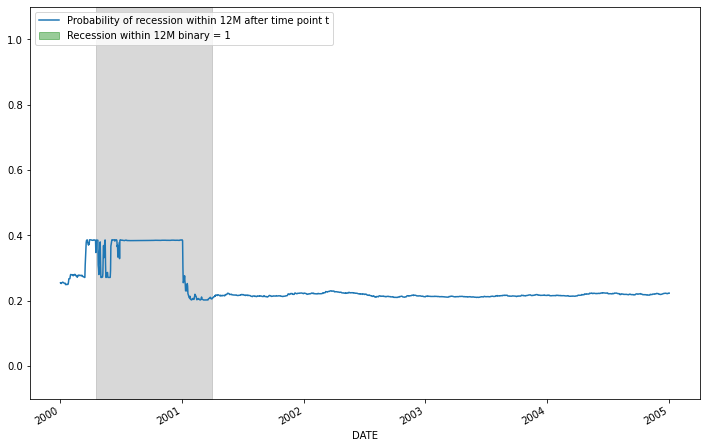

In [31]:
# Save results
results = X_test.copy()
results['Probability of recession within 12M after time point t'] = [x[1] for x in y_proba]
results['Recession within 12M binary'] = y_pred
results['y_true'] = y_test

# plot out-of-sample probability and binary prediction for GFC
ax = results['Probability of recession within 12M after time point t'].plot(figsize=(12,8))
ax.fill_between(results.index, -0.1, 1.1, where=results['Recession within 12M binary'], color='g', alpha=0.4, label='Recession within 12M binary = 1')
ax.fill_between(results.index, -0.1, 1.1, where=results['y_true'].values, color='gray', alpha=0.3)
ax.set_ylim((-0.1,1.1))
ax.legend(loc="upper left")


### calculate statistics

In [32]:
print('NN accuracy for out-of-sample period', round(accuracy_score(y_test, y_pred) * 100, 1), '%')
print('NN precision for out-of-sample period', round(precision_score(y_test, y_pred) * 100, 1), '%')
print('NN recall for out-of-sample period', round(recall_score(y_test, y_pred) * 100, 1), '%')

NN accuracy for out-of-sample period 80.9 %
NN precision for out-of-sample period 0.0 %
NN recall for out-of-sample period 0.0 %


/Users/lukas/miniconda3/envs/toolbox/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## bad performance: Why?
Too small sample size of training data??

As there is only the information about one recession in the training set the one could presume that this is the cause for the bad performance. Thus in the following, a Machine-Learning NO-GO is performed to get an indication if the bad performance is really caused by a lack of data.

In [50]:
# define date range used for training and testing
test_date_range = pd.date_range(start=pd.to_datetime('2000-01-02'), end=pd.to_datetime('2006-01-01'))

# split dataset. Here we only have test_date_range thus we split test_date_range from whole dataset and use the rest as training data
X_train = df[~df.index.isin(test_date_range)][features]
y_train = df[~df.index.isin(test_date_range)]['start_recession_next_12m']

X_test = df[df.index.isin(test_date_range)][features]
y_test = df[df.index.isin(test_date_range)]['start_recession_next_12m']

In [51]:
%%capture
# new model training
pipe.fit(X_train, y_train)
# predict out-of-sample
y_proba = pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)

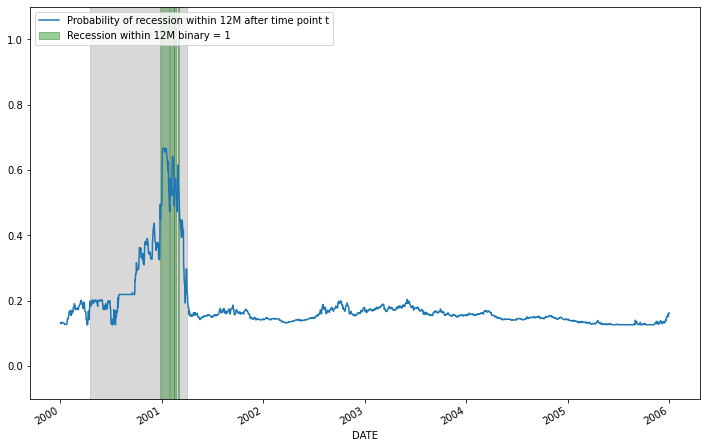

In [54]:
# Save results
results = X_test.copy()
results['Probability of recession within 12M after time point t'] = [x[1] for x in y_proba]
results['Recession within 12M binary'] = y_pred
results['y_true'] = y_test

# plot out-of-sample probability and binary prediction for GFC
ax = results['Probability of recession within 12M after time point t'].plot(figsize=(12,8))
ax.fill_between(results.index, -0.1, 1.1, where=results['Recession within 12M binary'], color='g', alpha=0.4, label='Recession within 12M binary = 1')
ax.fill_between(results.index, -0.1, 1.1, where=results['y_true'].values, color='gray', alpha=0.3)
ax.set_ylim((-0.1,1.1))
ax.legend(loc="upper left")

In [55]:
print('NN accuracy for out-of-sample period', round(accuracy_score(y_test, y_pred) * 100, 1), '%')
print('NN precision for out-of-sample period', round(precision_score(y_test, y_pred) * 100, 1), '%')
print('NN recall for out-of-sample period', round(recall_score(y_test, y_pred) * 100, 1), '%')

NN accuracy for out-of-sample period 86.8 %
NN precision for out-of-sample period 100.0 %
NN recall for out-of-sample period 17.0 %


Result: As we add further information about recessions the out-of-sample precision rises significantly. Thus, one can see that the more recessions are included in the dataset, the higher the prediction's accuracy. 

# Training: 1980-2006 Test: 2006-2012 (in practice)

## setup data

In [59]:
# define date range used for training and testing
train_date_range = pd.date_range(start=start, end=pd.to_datetime('2006-01-01'))
test_date_range = pd.date_range(start=pd.to_datetime('2006-01-02'), end=pd.to_datetime('2012-01-01'))

# split dataset according to pre-defined date ranges
X_train = df[df.index.isin(train_date_range)][features]
y_train = df[df.index.isin(train_date_range)]['start_recession_next_12m']

X_test = df[df.index.isin(test_date_range)][features]
y_test = df[df.index.isin(test_date_range)]['start_recession_next_12m']

## setup model and fit model on historic data until 2006

In [60]:
%%capture
# fit model 
pipe.fit(X_train, y_train)

## predict the following years 

In [61]:
%%capture
# predict out-of-sample
y_proba = pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)

# Save results
results = X_test.copy()
results['Probability of recession within 12M after time point t'] = [x[1] for x in y_proba]
results['Recession within 12M binary'] = y_pred
results['y_true'] = y_test

# plot out-of-sample probability and binary prediction for GFC
ax = results['Probability of recession within 12M after time point t'].plot(figsize=(12,8))
ax.fill_between(results.index, -0.1, 1.1, where=results['Recession within 12M binary'], color='g', alpha=0.4, label='Recession within 12M binary = 1')
ax.fill_between(results.index, -0.1, 1.1, where=results['y_true'].values, color='gray', alpha=0.3)
ax.set_ylim((-0.1,1.1))
ax.legend(loc="upper left")
ax1 = X_test.plot(kind='line', y=['T10Y2Y', 'T10Y3M'], figsize=(12,8))
ax1.plot(X_test.index, np.zeros(X_test.shape[0]), color='black')
ax1.fill_between(results.index, ax1.get_ylim()[0], ax1.get_ylim()[1], where=results['y_true'].values, color='gray', alpha=0.3)


### calculate statistics

In [62]:
print('NN accuracy for out-of-sample period', round(accuracy_score(y_test, y_pred) * 100, 1), '%')
print('NN precision for out-of-sample period', round(precision_score(y_test, y_pred) * 100, 1), '%')
print('NN recall for out-of-sample period', round(recall_score(y_test, y_pred) * 100, 1), '%')

NN accuracy for out-of-sample period 79.4 %
NN precision for out-of-sample period 31.7 %
NN recall for out-of-sample period 25.3 %


# Training: 1980-2018 Test: 2018-2022 (in practice)

In [71]:
tf.keras.utils.set_random_seed(
    1
)

## training

In [72]:
train_date_range = pd.date_range(start=start, end=pd.to_datetime('2018-01-01'))
test_date_range = pd.date_range(start=pd.to_datetime('2018-01-02'), end=pd.to_datetime('2022-01-01'))

# Train and test dataframes
df_train = df[df.index.isin(train_date_range)]
df_test = df[df.index.isin(test_date_range)]

X_train = df_train[features]
y_train = df_train['start_recession_next_12m']

X_test = df_test[features]
y_test = df_test['start_recession_next_12m']

## setup model and fit model on historic data until 2018

In [73]:
%%capture
# train new model
pipe.fit(X_train, y_train)

# predict out-of-sample
y_proba = pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)

## predict the following years 

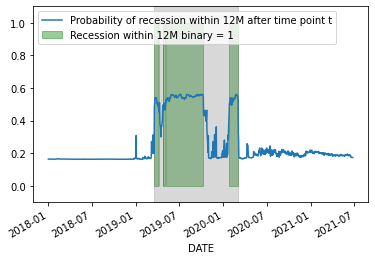

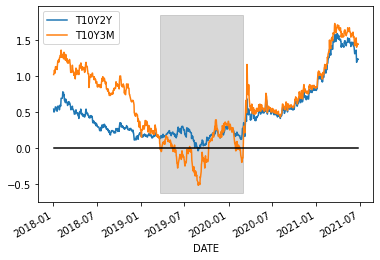

In [75]:
# Save results
results = X_test.copy()
results['Probability of recession within 12M after time point t'] = [x[1] for x in y_proba]
results['Recession within 12M binary'] = y_pred
results['y_true'] = y_test

# plot out-of-sample probability and binary prediction for GFC
ax = results['Probability of recession within 12M after time point t'].plot(figsize=(12,8))
ax.fill_between(results.index, 0, 1, where=results['Recession within 12M binary'], color='g', alpha=0.4, label='Recession within 12M binary = 1')
ax.fill_between(results.index, -0.1, 1.1, where=results['y_true'].values, color='gray', alpha=0.3)
ax.set_ylim((-0.1,1.1))
ax.legend(loc="upper left")
ax1 = X_test.plot(kind='line', y=['T10Y2Y', 'T10Y3M'], figsize=(12,8))
ax1.plot(X_test.index, np.zeros(X_test.shape[0]), color='black')
ax1.fill_between(results.index, ax1.get_ylim()[0], ax1.get_ylim()[1], where=results['y_true'].values, color='gray', alpha=0.3)


### calculate statistics

In [76]:
print('NN accuracy for out-of-sample period', round(accuracy_score(y_test, y_pred) * 100, 1), '%')
print('NN precision for out-of-sample period', round(precision_score(y_test, y_pred) * 100, 1), '%')
print('NN recall for out-of-sample period', round(recall_score(y_test, y_pred) * 100, 1), '%')

NN accuracy for out-of-sample period 90.0 %
NN precision for out-of-sample period 98.8 %
NN recall for out-of-sample period 64.4 %


# Train final model and predict current edge
Final model is the model that has indicated to be the most performant under TimeSeries-CV (derived in previous section).

In [78]:
tf.keras.utils.set_random_seed(
    1
)

## training and in-sample evaluation

In [79]:
%%capture

# fit model on whole dataset
pipe.fit(X, y)

# prediction in-sample
y_proba = pipe.predict_proba(X)
y_pred = pipe.predict(X)

## analyse the in-sample prediction

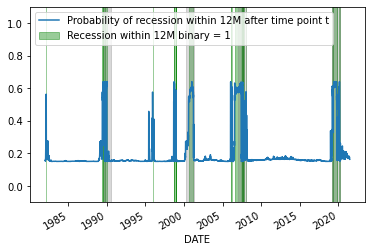

In [81]:
# In-Sample plot
df_plot = X.copy()
df_plot['Probability of recession within 12M after time point t'] = [x[1] for x in y_proba]
df_plot['Recession within 12M binary'] = y_pred
df_plot['y_true'] = y

# plot out-of-sample probability
ax = df_plot['Probability of recession within 12M after time point t'].plot(figsize=(12,8))
ax.fill_between(df_plot.index, -0.1, 1.1, where=df_plot['Recession within 12M binary'], color='g', alpha=0.4, label='Recession within 12M binary = 1')
ax.fill_between(df_plot.index, -0.1, 1.1, where=df_plot['y_true'].values, color='gray', alpha=0.3)
ax.set_ylim((-0.1,1.1))
ax.legend(loc="upper left")


## current edge prediction
Evaluate the current edge out-of-sample prediction.

In [84]:
%%capture
# create out-of-sample data set  / here: all data which is unlabeled
X_current_edge = df_total[df_total.index.isin(datelist)].drop('start_recession_next_12m', axis=1)

# predict on out-of-sample dataset
y_proba = pipe.predict_proba(X_current_edge)

(0.0, 1.0)

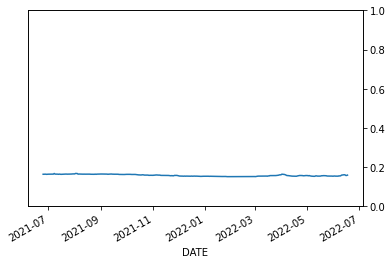

In [86]:
# Save results
results = X_current_edge.copy()
results['Probability of recession within 12M after time point t'] = [x[1] for x in y_proba]

# plot out-of-sample probability
ax = results['Probability of recession within 12M after time point t'].plot(secondary_y=True, figsize=(12,8))
ax.set_ylim((0,1))